# Text to speech generation

Text To Speech (TTS) models have made great strides in quality over the last few years. Unfortunately, it's not currently possible to use these libraries without installing a large number of dependencies.

The txtai TextToSpeech pipeline has the following objectives:

- Fast performance both on CPU and GPU
- Ability to batch large text values and stream it through the model
- Minimal install footprint
- All dependencies must be Apache 2.0 compatible

This notebook will go through a set of text to speech generation examples.



# Install dependencies

Install `txtai` and all dependencies. Since this notebook is using optional pipelines, we need to install the pipeline extras package. We'll also demonstrate running this pipeline as an application.

In [1]:

!pip install git+https://github.com/neuml/txtai#egg=txtai[pipeline-audio,pipeline-data] onnxruntime-gpu librosa

# Install NLTK
import nltk
nltk.download('averaged_perceptron_tagger_eng')

DEPRECATION: git+https://github.com/neuml/txtai#egg=txtai[pipeline-audio,pipeline-data] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/neuml/txtai to /tmp/pip-install-i_wsotnm/txtai_e331108afcdf45f1a037ed69361b4657
  Running command git clone --filter=blob:none --quiet https://github.com/neuml/txtai /tmp/pip-install-i_wsotnm/txtai_e331108afcdf45f1a037ed69361b4657
  Resolved https://github.com/neuml/txtai to commit 04d4bc43aad394778df6430d28de9ff7481ad89c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Create a TextToSpeech instance

The TextToSpeech instance is the main entrypoint for generating speech from text. The pipeline is backed by models from the [ESPnet](https://github.com/espnet/espnet) project. ESPnet has a number of high quality TTS models available on the [Hugging Face Hub](https://huggingface.co/models?library=espnet&pipeline_tag=text-to-speech&sort=downloads).

This pipeline can use the following models on the Hugging Face Hub.

- [ljspeech-jets-onnx](https://huggingface.co/NeuML/ljspeech-jets-onnx)
- [ljspeech-vits-onnx](https://huggingface.co/NeuML/ljspeech-vits-onnx)
- [vctk-vits-onnx](https://huggingface.co/NeuML/vctk-vits-onnx)

The default model is `ljspeech-jets-onnx`. Each of the models above are ESPnet models exported to ONNX using [espnet_onnx](https://github.com/espnet/espnet_onnx). More on that process can be found in the links above.


In [2]:
!pip install --upgrade torch torchvision torchaudio

In [3]:
%%capture

from txtai.pipeline import TextToSpeech

# Create text-to-speech model
tts = TextToSpeech()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


# Generate speech

The first example shows how to generate speech from text. Let's give it a try!

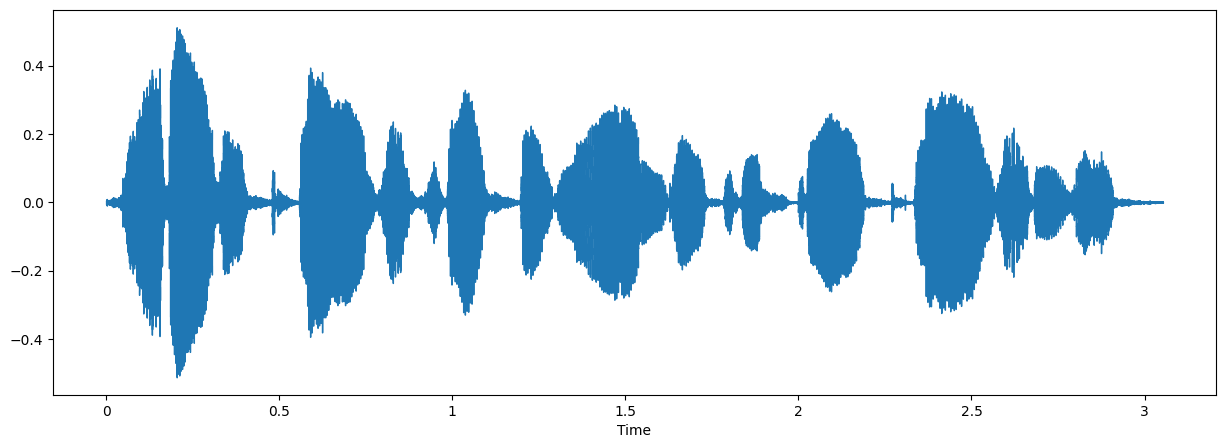

In [12]:
import librosa.display
import matplotlib.pyplot as plt

text = "soddhi class chethha la undhi today classssss "

# Generate raw waveform speech
speech, rate = tts(text), 22050

# Print waveplot
plt.figure(figsize=(15, 5))
plot = librosa.display.waveshow(speech[0], sr=speech[1])

The graph shows a plot of the audio. It clearly shows pauses between words and sentences as we would expect in spoken language. Now let's play the generated speech.

In [13]:
from IPython.display import Audio, display

import os

import soundfile as sf

def play(speech):
  # Convert to MP3 to save space
  sf.write("speech.wav", speech[0], speech[1])
  !ffmpeg -i speech.wav -y -b:a 64 speech.mp3 2> /dev/null

  # Play speech
  display(Audio(filename="speech.mp3"))

play(speech)

# Transcribe audio back to text

Next we'll use [OpenAI Whisper](https://github.com/openai/whisper) to transcribe the generated audio back to text.

In [9]:
from txtai.pipeline import Transcription

# Transcribe files
transcribe = Transcription("openai/whisper-base")

# Print result
transcribe(speech, rate)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


'So did he class.'

And as expected, the transcription matches the original text.

# Streaming speech generation

The TextToSpeech pipeline supports incrementally generating snippets of speech. This enables the pipeline to work with streaming LLM generation.

In [14]:
text = "This is streaming speech generation. It's designed to take output tokens from a streaming LLM. It returns snippets of speech.".split()
for speech, _ in tts(text, stream=True):
  print(speech.shape)

(32768,)
(31488,)
(26368,)


# Audio books

The TextToSpeech pipeline is designed to work with large blocks of text. It could be used to build audio for entire chapters of books.

In the next example below, we'll read the beginning of the book the `Great Gatsby`. We'll load a new model that enables setting a speaker.

In [15]:
# Beginning of The Great Gatsby from Project Gutenberg
# https://www.gutenberg.org/ebooks/64317

text = """
In my younger and more vulnerable years my father gave me some advice
that I've been turning over in my mind ever since.

“Whenever you feel like criticizing anyone,” he told me, “just
remember that all the people in this world haven't had the advantages
that you've had.”

He didn't say any more, but we've always been unusually communicative
in a reserved way, and I understood that he meant a great deal more
than that.
"""

tts = TextToSpeech("neuml/vctk-vits-onnx")
speech = tts(text, speaker=3)
play(speech)

model.onnx:   0%|          | 0.00/145M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/934 [00:00<?, ?B/s]

# Text To Speech Workflow

In the last example, we'll cover building a text-to-speech workflow. This workflow is no different in that it connects multiple pipelines together, each of which are backed by machine learning models.

The workflow extracts text from a webpage, summarizes it and then generates audio of the summary.

In [ ]:
%%writefile workflow.yml
summary:
  path: sshleifer/distilbart-cnn-12-6

textractor:
  join: true
  lines: false
  minlength: 100
  paragraphs: true
  sentences: false

texttospeech:
  path: neuml/vctk-vits-onnx

workflow:
  tts:
    tasks:
    - action: textractor
      task: url
    - action: summary
    - action: texttospeech
      args:
        speaker: 15

Overwriting workflow.yml


In [ ]:
from txtai.app import Application

app = Application("workflow.yml")

speech = list(app.workflow("tts", ["https://en.wikipedia.org/wiki/Natural_language_processing"]))[0]

play(speech)

# Wrapping up

This notebook gave a brief introduction on text to speech models. The text to speech pipeline in txtai is designed to be easy to use and handles the most common text to speech tasks in English.  

This work is made possible by the excellent advancements in text to speech modeling. [ESPnet](https://github.com/espnet/espnet) is a great project and should be checked out for more advanced and a wider range of use cases. This pipeline was also made possible by the great work from [espnet_onnx](https://github.com/espnet/espnet_onnx) in building a framework to export models to ONNX.

Looking forward to seeing what the community dreams up using this pipeline!

